<a href="https://colab.research.google.com/github/ivanrnarvaez/text_mining/blob/main/6_NER_master_alumnos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets seqeval gradio evaluate
!pip install fsspec==2023.9.2

# Introducción

El r**econocimiento de entidades nombradas (Named-Entity Recognition, NER)** es una técnica esencial en el procesamiento del lenguaje natural que permite identificar y clasificar fragmentos relevantes de texto en categorías predefinidas, como nombres de personas, organizaciones, ubicaciones, fechas… o, en el caso de este ejercicio guiado, **habilidades profesionales (skills)**.

**Por ejemplo**, a partir de un texto como:

> *Buscamos una persona con experiencia en Python, análisis de datos y modelado estadístico.*

Un sistema NER bien entrenado podría detectar y extraer entidades como `Python`,`análisis de datos` y `modelado estadístico`, que son habilidades profesionales de relevancia para desempeñar en una posición laboral como científico de datos.


**¿Por qué es útil?**


La extracción automática de este tipo de entidades es muy valiosa para los procesos de selección que llevan a cabo las empresas, ya que permite:

- Comparar de forma automatizada si las habilidades solicitadas en una oferta están presentes en los CVs de los candidatos. Y ordenar y priorizar los candidatos según su grado de adecuación a una posición.

- Extraer información estructurada de descripciones de puestos de trabajo y analizar tendencias del mercado laboral, detectando qué habilidades están siendo más demandadas en cada sector o región.

En este notebook, construiremos un modelo NER adaptado a este tipo de tareas, entrenado sobre textos reales y orientado a su aplicación en entornos profesionales.


En este notebook, construiremos un modelo NER adaptado a este tipo de tareas, entrenado sobre datos reales y orientado a su aplicación en entornos profesionales.



# Proceso Resumido

En este notebook se llevará a cabo el ciclo completo para entrenar un sistema de NER adaptado para la detección de *skills* profesionales.

Para ello, utilizaremos un **modelo de lenguaje** de tipo **encoder**, que ajustaremos para extraer este tipo de entidad del texto. Estos modelos son capaces de representar cada palabra (token) del texto según su contexto, lo que los hace ideales para tareas de extracción de entidades.

El flujo básico será el siguiente:

1. **Tokenización**: Se llevará a cabo la tokenización de los datos de entrenamiento, además de procesados específicos que permitan llevar a cabo el entrenamiento correctamente, como el alineamiento de entidades y subtokens.

2. **Fine-Tuning**:

  a. **Paso por el modelo de lenguaje**:
  A diferencia de tareas como la clasificación de textos, donde se utiliza el token especial `[CLS]` como representación del texto completo, en NER trabajamos con los vectores contextualizados de cada token individual. Esto permite al modelo identificar patrones en secuencias de palabras que indican la presencia de una entidad (como una habilidad).

  b. **Clasificación head**:
  Cada uno de estos vectores es pasado por una capa de clasificación que aprenderá a detectar patrones contextuales para identificar si un token forma parte de una entidad o no.

  👉 Este enfoque convierte el problema en una tarea de **clasificación de tokens**, donde cada token será clasificado individualmente y se le asignará una etiqueta como SKILL o no SKILL, siguiendo un esquema como B-SKILL, I-SKILL, O, etc.

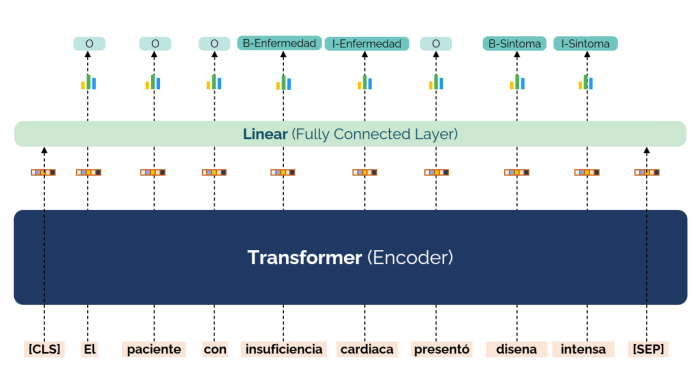

# Descarga y preparación de datos

Para entrenar un modelo NER necesitamos datos etiquetados: textos donde las entidades ya estén marcadas. En este caso, trabajaremos con el [**corpus de SkillSpan**](https://aclanthology.org/2022.naacl-main.366/), un dataset diseñado específicamente para el reconocimiento de skills y conocimientos en descripciones de ofertas de trabajo.

En esta sección descargaremos los datos, los cargaremos como objeto Dataset de Huggingface, y llevaremos algunas preparaciones de datos.

En primer lugar, descargamos los datos de entrenamiento, desarrollo y test del [**repositorio de SkillSpan**](https://github.com/kris927b/SkillSpan):

In [ ]:
#Download data
!wget https://github.com/kris927b/SkillSpan/raw/refs/heads/main/data/json/train.json
!wget https://github.com/kris927b/SkillSpan/raw/refs/heads/main/data/json/test.json
!wget https://github.com/kris927b/SkillSpan/raw/refs/heads/main/data/json/dev.json

Estos datos, siguen el formato IOB, y están guardados en un archivo JSON con la siguiente estructura:



```json
{
  "idx": 1,
  "tokens": ["Full", "Stack", "Software", "Engineer", "-", "Java", "/", "JavaScript"],
  "tags_skill": ["O", "O", "O", "O", "O", "O", "O", "O"],
  "tags_knowledge": ["O", "O", "O", "O", "O", "O", "O", "O"],
  "source": "tech"
  }
```

Donde se observa que cada frase ya está tokenizada, y se identifica la presencia de tokens con entidades de tipo skill o conocimiento utilizando el esquema IOB (sólo O en el caso del ejemplo mostrado)



A continuación, utilizamos la función `load_dataset()` para cargarlos como objetos *Datasets* que puedan funcionar con la librería Transformers del entorno Huggingface.

In [ ]:
from datasets import load_dataset
train_set = load_dataset("json", data_files=_____________, split="train")  # "train.json"
dev_set = load_dataset("json", data_files=_____________, split="train")  # "dev.json"
test_set = load_dataset("json", data_files=_____________, split="train")  # "test.json"

Por temas de visualización posteriores, vamos a sustituir las etiquetas `B` e `I` por `B-SKILL` y `I-SKILL`. Para ello definimos una función `convert_tags()` que procese cada elemento del Dataset, buscando en el campo *tags_skill* para llevar a cabo la sustitución:

In [ ]:
def convert_tags(example):
    example["tags_skill"] = [
        "B-SKILL" if tag == "B" else
        "I-SKILL" if tag == "I" else
        "O"
        for tag in example["tags_skill"]
    ]
    return example

In [ ]:
train_set = train_set.map(convert_tags)
dev_set = dev_set.map(convert_tags)
test_set = test_set.map(convert_tags)

Indicamos que la columna *tags_skill* es de tipo **ClassLabel** (una variable categórica) con 3 clases: `0`,`B-SKILL` y `I-SKILL`. De esta manera, nos aseguramos que el modelo reciba al entrenar estas etiquetas como índices (0,1 y 2), no como texto; pero posteriormente podamos obtener como predicciones los valores como textos.


In [ ]:
from datasets import Dataset, DatasetDict, ClassLabel, Sequence
ordered_tags = ["O", "B-SKILL", "I-SKILL"]
class_label = ClassLabel(names=ordered_tags)
features = train_set.features.copy()
features["tags_skill"] = Sequence(class_label)

train_set = train_set.cast(features)
dev_set = dev_set.cast(features)
test_set = test_set.cast(features)

Por último generamos un objeto `DatasetDict` para guardar cada partición del corpus:

In [ ]:
split_datasets = DatasetDict({
    'train': ________________,  # train_set
    'test': ________________, # test_set
    'validation': ________________  # dev_set
})

Podemos mirar la estructura del archivo:

In [ ]:
split_datasets["train"][0:2]

In [ ]:
split_datasets

Los conjuntos de datos contienen un conjunto de datos de entrenamiento, validación y test. En este caso, el dataset de skillspan contiene 4800 frases de entrenamiento, 3569 frases para validación y 3174 frases de test.


Cada uno de los subsets es de la clase `Dataset`. Se puede acceder a diferentes atributos como *column_names*. Se puede consultar el tipo de cada una de las columnas utilizando el atributo *features*.

In [ ]:
print("Columnas del subset de train.")
print(split_datasets["train"].column_names)

print("Tipo de cada columna")
print(split_datasets["train"].features)

Vamos a ver el tipo de etiquetas que tienen los datos:

In [ ]:
tags = split_datasets["train"].features["tags_skill"].feature

In [ ]:
tags

Si hacemos un print del campo "tags_skill", vemos que cada una de las clases se almacena en formato numérico, siendo cada índice asociado a un nombre de los valores de `ClassLabel`

In [ ]:
print(tags)
print(split_datasets["train"][0]["tags_skill"])

Como los valores numéricos no son fácilmente comprensibles, vamos a generar una función llamada `create_tag_names` que cree un campo llamado "ner_tags_str" dentro de cada elemento del dataset.

In [ ]:
def create_tag_names(batch):
  return {"ner_tags_str": [tags.int2str(x) for x in batch["tags_skill"]]}

split_datasets_m = split_datasets.map(create_tag_names)

## Exploración de datos

Ahora comprobamos que se ha generado correctamente:

In [ ]:
import pandas as pd

In [ ]:
fila = 901
ejemplo_df_ = pd.DataFrame([split_datasets_m["train"][fila]["tokens"],split_datasets_m["train"][fila]["ner_tags_str"],split_datasets_m["train"][fila]["tags_skill"]], ["tokens","tags","tag_id"])

In [ ]:
ejemplo_df_._______________ #T

Vamos a comprobar el número de frases con las que contamos en cada partición de datos, aśi como el nuḿero de tokens:

In [ ]:
for i in ["train","validation","test"]:
  # Número total de frases
  num_sentences = len(____________) #split_datasets[i]

  # Número total de tokens
  num_tokens = sum(len(example["tokens"]) for example in split_datasets[i])

  print(f"Número de frases en {i}: {num_sentences}")
  print(f"Número total de tokens en {i}: {num_tokens}")
  print(f"----------------------------")

¿Cuál es la distribución de categorías de tokens en cada partición?

En este punto, vamos a hacer un pequeño preprocesado para ver el número de etiquetas en cada subconjunto de datos:

In [ ]:
from collections import Counter, defaultdict

# Creamos diccionario de tipo Counter donde guardaremos resultados del contador
split2freqs = defaultdict(Counter)
# Itera por cada sub split
for split, dataset in split_datasets_m.items():
  # Itera por cada fila del subset split
  for row in dataset["ner_tags_str"]:
    # Para cada lista de etiquetas de cada fila iteramos
    for tag in row:
      if tag.startswith("B"):
        tag_type=tag
        split2freqs[split][tag_type] +=1
      if tag.startswith("I"):
        tag_type=tag
        split2freqs[split][tag_type] +=1
      if tag.startswith("O"):
        tag_type=tag
        split2freqs[split][tag_type] +=1

# Una vez finalizamos mostramos en pantalla
pd.DataFrame.from_dict(split2freqs, orient="index")

Observamos que:

- **Dominancia de la clase `O`**: En los tres conjuntos la mayoría de los tokens están etiquetados como O, lo cual es normal en tareas NER: la mayoría de las palabras no pertenecen a ninguna entidad.

- **Proporción estable entre splits**: Las proporciones de B-SKILL e I-SKILL son bastante similares entre los conjuntos. Esto es bueno porque sugiere que la segmentación se hizo de forma estratificada, manteniendo la misma distribución de clases.

- **Más tokens I-SKILL que B-SKILL**:Esto también es esperable, porque muchas skills son frases con varios tokens ("deep learning", "natural language processing").

# Tokenización de datos


Como se ha visto, los textos ya vienen tokenizados a nivel de palabra en el conjunto de datos descargado. Sin embargo, cuando se usan modelos de lenguaje la tokenización de los términos que los componen se realiza a nivel de subpalabra ("**subword**"), esto introduce un reto: ** ¿cómo etiquetamos correctamente si una palabra se divide en varios subtokens?**

Para ver la tokenización del texto vamos a cargar el objeto AutoTokenizer, que se utilizará para descargar el tokenizador de un modelo de lenguaje pre-entrenado en español. Además, generamos diccionarios de mapeos entre etiquetas e índices de las categorías del corpus:

In [ ]:
from transformers import AutoTokenizer
model_name = _________________________  # "answerdotai/ModernBERT-base"

In [ ]:
tokenizer = _______________________ # AutoTokenizer.from_pretrained(model_name)

In [ ]:
indice2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2indice = {tag: idx for idx, tag in enumerate(tags.names)}

### Explicación problema de alineación de etiquetas

En el siguiente ejemplo, las palabras desde "developing" hasta "applications" han sido etiquetadas como una entidad de tipo SKILL, siguiendo el esquema IOB.



In [ ]:
text = "Competent with developing multithreaded scalable concurrent applications."
original_tokens = ["Competent", "with", "developing", "multithreaded", "scalable", "concurrent", "applications", "."]
original_labels = ["O", "O", "B", "I", "I", "I", "I", "O"]

Al pasar el texto por un tokenizador:

In [ ]:
print(tokenizer.tokenize(text))

['Comp', 'et', 'ent', 'Ġwith', 'Ġdeveloping', 'Ġmult', 'ith', 'read', 'ed', 'Ġscalable', 'Ġconcurrent', 'Ġapplications', '.']


Al pasar las palabras por el tokenizador, observamos que las etiquetas originales están asociadas a palabras completas, pero después de tokenizar cada palabra se puede convertir en varios subtokens. Es decir que necesitamos una función que:

a. Asocie cada subtoken con la etiqueta de su **palabra original**

b. Para los **primeros subtokens**, mantenga la etiqueta original (B, I o O)

c. Para los **subtokens siguientes** se asigna la etiqueta *IGN*. Estos subtokens que con valor "IGN", se les asignará un índice de **-100**, esto evitará que se utilicen esos valores en el calculo de la **loss**, algo importante para no penalizar al modelo en aquellos tokens compuestos por varias subpalabras, ya que si predecimos el primer subtoken el segundo se puede inferir que tiene la misma etiqueta.


Trabajaremos con el mismo ejemplo de antes. Observamos que las subpalabras de un mismo token tienen el mismo identificador de palabra.

In [ ]:
import pandas as pd
# Primero codificaríamos el texto con el tokenizador:
elemento = 38
words, labels = split_datasets_m["test"][elemento]["tokens"], split_datasets_m["test"][elemento]["tags_skill"]

tokenized_input = tokenizer(words,is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids],index=["Tokens", "word ids"])


Vamos a desarrollar una función que asigne a aquellas subpalabras con el mismo word_ids, una etiqueta "IGN" y un label ids de -100:

In [ ]:

# variables auxiliares
previous_word_idx = None
label_ids = []
# Iteramos por cada identificador de subtokens.
for word_idx in word_ids:
  # Si el word_idx es None o igual que el anterior significa que es o bien token s o subword.
  if word_idx is None or word_idx == previous_word_idx:
    # Añadimos un identificador -100 que será ignorado durante la evaluación del modelo
    # (Durante el calculo de la loss)
    label_ids.append(-100)
  # Si el token es distintito, guardamos el identificador numérico de la etiqueta del token
  elif word_idx != previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx
# Generamos una lista sustituyendo los valores numéricos de las etiquetas (label_ids) por sus strings
# Si el valor es -100 lo sustituimos por IGN (ignorar)
labels = [indice2tag[l] if l != -100 else "IGN" for l in label_ids]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=["tokens","word ids","label ids","labels"])


En esta tabla, cada fila representa una dimensión distinta del procesamiento de texto en tareas de clasificación de tokens.

- La fila de **tokens** contiene los subtokens generados por el tokenizer, ya que una palabra puede dividirse en varios fragmentos.

- La fila de **word ids** indica a qué palabra original pertenece cada subtoken; si aparece como None, significa que ese token es especial (como [CLS] o [SEP]) y no corresponde a ninguna palabra del texto original.

- La fila de **label ids** contiene los valores numéricos utilizados como etiquetas durante el entrenamiento. Un valor de -100 señala que ese token debe ser ignorado en la función de pérdida (loss), esto se aplica a los tokens especiales y a los subtokens que no son el primero de una palabra.  Evita que el modelo se entrene sobre fragmentos parciales de palabra, focalizando la detección del comienzo de éstas para el aprendizaje.

- Finalmente, la fila de **labels** muestra las etiquetas en formato legible, como las del esquema IOB (B-SKILL, I-SKILL y O, consturidos utilizando los lbel_ids



### Tokenizacion del corpus

Una vez explicado, generamos una función que permita escalar este procesado a todo el corpus. Por una parte generarmos una función que tokenize los datos que se introduzcan de entrada y haga el procesado de las celdas anteriores. Además, generaremos una función para aplicar esa función con un `map()` al corpus.

In [ ]:
def tokenize_and_align_labels(examples):
  # Tokenizamos la entrada, ya en tokens (esto es muy importante!).
  tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
  labels = []
  for idx, label in enumerate(examples["tags_skill"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    previous_word_idx=None
    label_ids = []
    for word_idx in word_ids:
        if word_idx is None or word_idx == previous_word_idx:
          label_ids.append(-100)
        else:
          label_ids.append(label[word_idx])
        previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs


Función para procesar cada split:

In [ ]:
def encode_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True, remove_columns = ["idx","tags_knowledge","tokens","source","tags_skill"])

Aplicación de las funciones sobre el corpus completo:

In [ ]:
split_datasets_m_encoded = ________________________ # encode_dataset(split_datasets_m)

Después de aplicar la función, vemos que el corpus ya sólo tiene las features requeridas para el entrenamiento.

In [ ]:
split_datasets_m_encoded["test"][38]["labels"]

# Fine-Tuning

Una vez que tenemos nuestros datos tokenizados, es hora de crear el modelo, configurar los parámetros de entrenamiento y definir cómo queremos evaluar su rendimiento.


In [ ]:
import torch
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Para realizar el ajuste de los modelos se necesitan generar objetos que permitan llevar a cabo esta tarea. Estas clases se pueden desarrollar ad-hoc utilizando la sintaxis de Pytorch o utilizar la librería Transformers, que proporciona clases de Python para facilitar el fine-tuning de estos modelos pre-entrenados.

La idea de estas clases es incorporar un "head" al modelo pre-entrenado que sea capaz de clasificar cada uno de los tokens de entrada al modelo, como se presenta en la figura. En el caso de ajuste de un LM para NER, se necesita cargar una capa de clasificación que tome la representación vectorial de cada token y que permita ajustar los pesos durante el back-propagation.



<center><img src="https://www.oreilly.com/api/v2/epubs/9781098136789/files/assets/nlpt_0404.png" alt="Estructura entrenamiento NER (O'reilly book)" width="150"/></center>




## Definición de métricas de evaluación


Un sistema NER se evalua con métricas similares a un sistema de clasificación de textos: Precision, Recall y $F_1$-score. Para hacer la evaluación de un modelo NER se utilizará la librería recomendada por los autores de la librería Transformers, [seqeval](https://github.com/chakki-works/seqeval). Esta librería toma en su entrada una lista de listas, en la que cada lista interna se compone de un conjunto de etiquetas que se comparan para obtener resultados de rendimiento.

In [ ]:
from seqeval.metrics import classification_report

true_values = [["O","O","O","B","I","O"],
               ["O","B","O"]]
pred_values  = [["O","O","O","B","O","O"],
               ["O","B","O"]]
print(classification_report(true_values,pred_values))

**De la secuencia 1:**

- Real: ["O", "O", "O", "B", "I", "O"]
- Predicho:["O", "O", "O", "B", "O", "O"]

Aquí, el modelo no reconoció correctamente la entidad "B I". Solo detectó "B", y no la continuó, así que es un error.

**De la secuencia 2:**

- Real: ["O", "B", "O"]
- Predicho:["O", "B", "O"]

Aquí el modelo sí lo hizo bien, reconoció una entidad de un solo token

Lo que se evalua es la **integridad de la entidad completa.**



En ese caso, sólo uno de las dos predicciones ha sido predicho correctamente, así que la precisión y recall será de 0.5.

Dado que las evaluaciones se harán con esa librería, que en su entrada toma una lista de listas, se preparará una función para preparar las predicciones y etiquetas verdaderas de cada muestra en este formato:

In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
  # Obtenemos prediccionnes
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  #  en cada batch de datos
  for batch_idx in range(batch_size):
    # Generamos muestras de true_values y predicciones en formato seq-eval
    example_labels, example_preds = [], []
    # Para cada documento
    for seq_idx in range(seq_len):
      # Ignoramos etiquetas que sean -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(indice2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(indice2tag[preds[batch_idx][seq_idx]])

    labels_list.append(example_labels)
    preds_list.append(example_preds)

  return preds_list, labels_list

Generamos la función **compute_metrics**, que calcule el score obtenido en cada paso de evaluación durante el entrenamiento sobre el conjunto de validación. En este caso generaremos una función que permita evaluar esto a través de la función `align_predictions` creada con anterioridad


In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true,y_pred)}

## Configuración del Entrenamiento del Modelo

Primero generamos los atributos principales de entrenamiento del modelo:

In [ ]:
# Cargamos la clase
from transformers import TrainingArguments

# Definimos algunos parámetros de configuracion
num_epochs = _________________ # 2
batch_size = _________________ # 8
logging_steps = len(split_datasets_m_encoded["train"]) // batch_size
model_name_save = f"output-model"

Posteriormente generamos la clase de argumenos de entrenamiento que utilizaremos posteriormente. Esta clase requiere introducir parámetros de configuración de entrenamiento a modelo a través de la clase `TrainingArguments`. Utilizando esta clase se le proporciona información como el número de epocas de entrenamiento, el batch_size, la estrategia de evaluación...


In [ ]:
import random
import numpy as np
import torch

def set_seed(seed=52):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(52)

In [ ]:
training_args = TrainingArguments(
    output_dir = model_name_save, log_level = "error",
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    save_steps=50,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=50,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    seed=52,
    full_determinism=True
)

## Entrenamiento del modelo

Una vez generadas todas las funciones necesarias para el entrenamiento, vamos a hacer el ajuste del modelo. Para ello vamos a beneficiarnos de clase [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer).



In [ ]:
from transformers import AutoConfig
model_config = AutoConfig.from_pretrained(model_name,
                                            num_labels = tags.num_classes,
                                            id2label = indice2tag,
                                            label2id = tag2indice)

- **`data_collator`**: Esta función lo que hará es ajustar las secuencias de entrada para que tengan todas la misma longitud. Este padding también se hace sobre las etiquetas que van a ser predichas. Para ello utilizamos las clases existentes en la librería transformers.

Todos las entradas en un batch deben tener la misma longitud en tokens Para ellos: Detectar la longitud más larga del batch y aplicar el padding dinámicamente a los ejemplos más cortos para que todos tengan la misma longitud

- Ejemplo 1: [CLS] I am happy [SEP]  (5 tokens)

- Ejemplo 2: [CLS] You are amazing today [SEP] (6 tokens)


Al introducirlos al modelo, se rellenan con tokens especiales de padding, para que la longitud sea la misma.

- [CLS] I     am     happy   [SEP] [PAD]  (6 tokens)
- [CLS] You   are    amazing today [SEP]  (6 tokens)


In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer,return_tensors="pt")

- **`model_init`**: Función que permite pre-cargar el modelo que va a ser ajustado.


In [ ]:
from transformers import AutoModelForTokenClassification
def model_init():
    return AutoModelForTokenClassification.from_pretrained(
    model_name, config=model_config
)
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config)



In [ ]:
from transformers import Trainer
trainer = Trainer(model = _____________, # model
                  args = _____________, # training_args
                  data_collator = _____________, # data_collator
                  compute_metrics = _____________, # compute_metrics
                  train_dataset = split_datasets_m_encoded["train"],
                  eval_dataset = split_datasets_m_encoded["validation"],
                  tokenizer = tokenizer)

Una vez creado el objeto es tan sencillo como entrenar utilizando el método `.train()`:

In [ ]:
trainer._________________________ # train()

A continaución analizemos las cúrvas de pérdida:

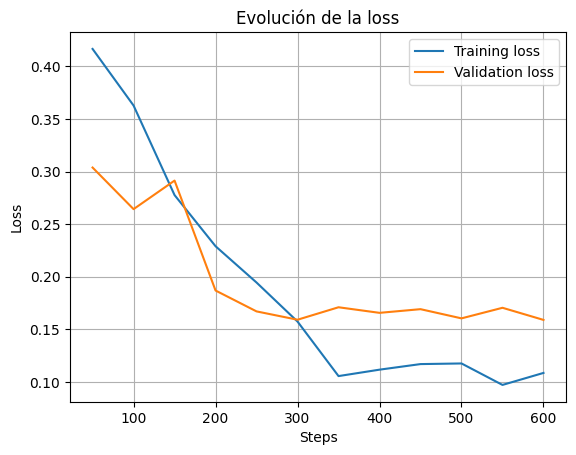

In [ ]:
# Mostrar curva de pérdida usando los logs del trainer
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.state.log_history)
# Separar las filas de entrenamiento y evaluación
train_rows = df[df["loss"].notna()].copy()
eval_rows = df[df["eval_loss"].notna()].copy()

# Fusionar por columna 'step'
combined = pd.merge(train_rows, eval_rows, on="step", suffixes=("_train", "_eval"))


# Filtramos solo los pasos con loss y eval_loss
loss_log = combined[["step", "loss_train", "eval_loss_eval"]].dropna()

plt.plot(loss_log["step"], loss_log["loss_train"], label="Training loss")
plt.plot(loss_log["step"], loss_log["eval_loss_eval"], label="Validation loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Evolución de la loss")
plt.legend()
plt.grid()
plt.show()

La gráfica muestra una evolución típica del entrenamiento de un modelo, donde el loss de entrenamiento disminuye de forma constante, mientras que el loss de validación baja inicialmente pero luego se estabiliza con pequeñas oscilaciones. Esto indica que el modelo aprende bien al principio, pero a partir de cierto punto (alrededor del paso 300) comienza a mostrar signos de sobreajuste, ya que mejora en los datos de entrenamiento pero no en los de validación. Sería recomendable aplicar estrategias como early stopping o regularización para evitar que el modelo pierda capacidad de generalización.

Si se había habilitado la opción de `push_to_hub=True` en el objeto  `TrainingArguments`, se puede hacer un push del modelo a HuggingFace Hub.

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

Si se quisiera, el modelo también se podría guardar en un directorio local para utilizarlo con posterioridad. Para ello se puede utilizar el método `.save_model()`, que permite guardar los archivos del modelo ajustado en un directorio local:

In [ ]:
trainer.save_model("output_model_save")

## Evaluación del modelo

Una vez entrenado el modelo de reconocimiento de entidades y visto su funcionamiento en una frase específica, ya podríamos evaluar el rendimiento del modelo sobre el conjuntos de datos de test:

In [ ]:
# Descargo y vuelvo a cargar el modelo anterior para llevar a cabo la evaluacíon.
model_id = "luisgasco/model_ner_master"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForTokenClassification.from_pretrained(model_id)
trainer = Trainer(
    model=model,
    args = training_args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset = split_datasets_m_encoded["train"],
    eval_dataset = split_datasets_m_encoded["validation"],
    tokenizer = tokenizer
)

Para ello, en primer lugar utilizamos el modelo para predecir los datos sobre el conjunto de test.

In [ ]:
predictions_test = trainer._________________ 3 predict(split_datasets_m_encoded["test"])

En esta ocasión, para calcular las métricas de rendimiento sobre el conjunto de datos de test, vamos a descargar unas métricas predefinidas en la liberíra Datasets, especificamente utilizando la clase [`load_metrics()`](https://huggingface.co/docs/datasets/v2.7.1/en/loading#metrics).

Con ese método se descargarán los métodos de evaluación presentes en seqeval, y podremos utilizar el objeto para obtener los resultados de evaluación:

In [ ]:
import evaluate
metric = evaluate.load("seqeval")

# Obtenemos las predicciones y las etiquetas por cada lado
predictions, labels = predictions_test.predictions,predictions_test.label_ids
predictions = np.argmax(predictions, axis=2)

# Obtenemos las predicciones verdaderas y las predichas y las guardamos en una lista
true_predictions = [
        [indice2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
true_labels = [
    [indice2tag[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
# OBtenemos los resultados de la evaluación a través del método compute.
results = metric.compute(predictions=true_predictions, references=true_labels)

In [ ]:
results

## Análisis de error <a name="id3_5_4"></a>

Una vez y entrenado el modelo siempre surge una pregunta de forma recurrente: **¿cómo podríamos mejorarlo?**

Para llevar a cabo un proceso de mejora de un modelo de inteligencia artificial es necesario llevar a cabo un **análisis exhaustivo de errores de predicción** en el conjunto de datos de validación y/o test. Esto permitirá identificar problemas en las predicciones que nos ayuden a:

- Detectar fallos de anotación recurrentes que permitan corregir los datos o refinar las guías de anotación si fuera necesario.
- Identificar fallos de predicción del sistema provocados por falta de datos.
- Identificar posibles post-procesados que permitan mejorar el rendimiento del sistema sin un re-entrenamiento.

Además, si el modelo funciona mucho peor de los esperado, analizar los errores puede ayudarnos a identificar problemas de preprocesado de datos, de evaluación de resultados o cualquier otro tipo de *bug* en nuestro código.


##### Preparación datos

Para llevar a cabo el análisis de error, vamos a generar una función que permita procesar los datos de validación o de test y que nos permita obtener el *loss* y las etiquetas predichas para cada token. El *loss* es una métrica que representa si un token es correcto o incorrecto, a un valor mayor el token tendrá una probabilidad mayor de ser incorrecto.

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convertimos los datos en una lista de diccionarios para que puedan ser procesados por el
    # data collator.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Padding de las entradas y etiquetas para obtener las predicciones.
    new_batch = data_collator(features)
    input_ids = new_batch["input_ids"].to(device)
    attention_mask = new_batch["attention_mask"].to(device)
    labels = new_batch["labels"].to(device)
    with torch.no_grad():
        # Pasa los datos a través del modelo
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predecimos la clase más probable como aquella que tenga el logit más alto.
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculamos la loss por token. La los en NER está siendo cross_entroy
    loss = cross_entropy(output.logits.view(-1, tags.num_classes),
                         labels.view(-1), reduction="none")
    # Hacemos el unflatten para ponerlo en formato de salida
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}


El dataset de validación procesado anteriormente tiene un campo `ner_tags_str` que habría que eliminar para que no hubiera error al aplicar la función anterior.

In [ ]:
#Eliminamos campos innecesarios
valid_set = split_datasets_m_encoded["validation"]
valid_set = valid_set.map(batched=True, batch_size=32,
                      remove_columns=['ner_tags_str'])
# Aplicamos la función anterior y la transformamos en un pandas dataframe.
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
valid_df = valid_set.to_pandas()

In [ ]:
valid_df.head(1)

Si observamos el dataframe, se ve que en la columna *labels*, *input_ids* y *predicted_label* contiene valores numéricos, lo que puede provocar problemas durante el análisis de los resultados por dificultad en su interpretabilidad. A continuación vamos a transformar esos valores numéricos por strings.

In [ ]:
# Creamos el indice -100 en el diccionario indice2tag
indice2tag[-100] = "IGN"
# Convertimos los identificadores de token en su forma string
valid_df["input_tokens"] = valid_df["input_ids"].apply(lambda x: tokenizer.convert_ids_to_tokens(x))
# Sustituimos las etiquetas predichas por la etiqueta en string
valid_df["predicted_label"] = valid_df["predicted_label"].apply(lambda x: [indice2tag[i] for i in x])
valid_df["labels"] = valid_df["labels"].apply(lambda x: [indice2tag[i] for i in x])
valid_df['loss'] = valid_df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
valid_df['predicted_label'] = valid_df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
valid_df.head(1)

Además, de cara a hacer análisis a nivel de subword, a partir del dataframe anterior vamos a generar un dataframe en el que cada fila sea una subpalabra, con sus atributos asociados como columnas (incluyendo su ´loss´ y su ´predicted_label´

In [ ]:
df_tokens = valid_df.apply(pd.Series.explode)
# Vamos a ignorar los token IGN.
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(3)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,11148,1,O,0.0,O,Dev
0,19217,1,O,0.0,O,Engine
0,9,1,O,0.0,O,(


Una vez tengamos los datos preparados, podemos empezar a hacer algunos análisis de error.



##### Losses per token

En primer lugar, mostraremos un análisis de error típico, que es analizar el valor agregado de la *loss* para cada token del conjunto de datos. Esto permite identificar si hay errores de predicción altos tanto en tokens frecuentes (con el valor medio) como poco frecuentes ( con la suma y el conteo de ocurrencias del token).

Para realizar este análisis vamos a calcular el número de veces que aparece cada token en los datos, así como la suma total de su *loss* y el valor medio.

In [ ]:
df_tokens_loss_token = df_tokens.groupby("input_tokens")[["loss"]].agg(["count", "mean", "sum"]).droplevel(level=0, axis=1)# Elimnamos columnas con más de un nivel

###### Tokens con loss total más alta

Por ejemplo, podríamos mostrar los tokens que tengan un valor total de *loss* más alto:

In [ ]:
(
    df_tokens_loss_token
    .sort_values(by=["sum"], ascending=False)
    .reset_index()
    .round(2)
    .head(20)
)

Observando esa tabla se pueden llegar a algunas conclusiones:

1. **Tokens funcionales comunes**
Tokens como `and`, `the`, `of`, `to`, `in`, `a`, `on`, `be`:
  - Son muy frecuentes.
  - Tienen un **loss promedio moderado** (entre 0.15 y 0.22).
  - Aunque no son individualmente problemáticos, su **alta frecuencia los hace acumular mucho loss total**.
  - Posible causa: el modelo puede tener dificultades para identificar correctamente los límites de las entidades cuando están cerca de estas palabras.

2. **Preposiciones y conectores relevantes**
Tokens como `with`, `for`, `our`:
  - Tienen **loss promedio más alto** (entre 0.25 y 0.29).
  - Estos tokens suelen estar cerca de entidades, y pueden introducir **ambigüedad contextual**.
  - El modelo puede tener dudas sobre si lo que sigue debe ser etiquetado como entidad.

3. **Tokens de contenido informativo**
Tokens como `development`, `work`, `develop`, `data`, `team`, `management`, `business`:
  - Tienen un **loss promedio elevado** (de 0.32 hasta 0.82).
  - Aunque aparecen menos, su impacto por token es alto.
  - Suelen formar parte de **entidades compuestas o polisémicas** (ej.: "business development").
  - Posible causa: el modelo falla en **reconocer los límites de la entidad o aplicar la etiqueta correcta**.



###### Tokens con avg loss

Vamos a ordenar los datos por avg loss más alto, pero filtrando el número de veces que haya aparecido el token como mínimo, ya que esto evitará mostrar errores poco frecuentes.

In [ ]:
filtrado = df_tokens_loss_token.sort_values(by=["mean"], ascending=False).reset_index().round(2)
min_freq = 20
filtrado.loc[filtrado["count"]>min_freq].head(15)

##### Losses per label

En segundo lugar, mostraremos las etiquetas con un  *loss*  más alto. En el caso de este notebook, en el que hemos entrenado un sistema NER que sólo tiene que predecir una etiqueta, no aporta mucha información, pero nos puede ayudar a identificar la magnitud de problemas a la hora de predecir entidades de más de un token analizando la etiqueta "I-ETIQUETA".


Para realizar este análisis vamos a calcular el número de veces que aparece cada etiqueta en los datos, calculando la suma total de su *loss* y el valor medio.

In [ ]:
df_tokens_loss_label = df_tokens.groupby("labels")[["loss"]].agg(["count", "mean", "sum"]).droplevel(level=0, axis=1)# Elimnamos columnas con más de un nivel

In [ ]:

(
    df_tokens_loss_label
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)


,0,1,2
labels,B-SKILL,I-SKILL,O
count,1070,3797,35190
mean,1.19,1.08,0.06
sum,1270.65,4113.4,2212.36


La loss más grande es la relaccionada con la etiqueta I-SKILL, lo que podría significar que el modelo identifica bien lso comienzos de entidades pero tiene problemas para detectar las entidades completas.

##### Matriz de confusión

También se puede generar una matriz de confusión pque permita evaluar cuantas veces se equivocó a la hora de asignar las etiqetas en los tokens y ver con que clase fueron clasificadas por el modelo.

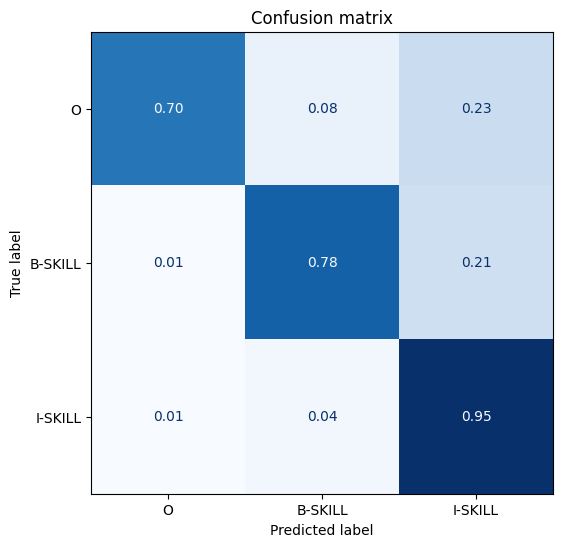

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels, normalizado = "true"):
    cm = confusion_matrix(y_true, y_preds, normalize=normalizado)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()


plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names,normalizado="true")

Por ejemplo, en la matriz de confusión se observa que hay un 23% de etiquetas de tipo B-SKILL, que representan el inicio de una entidad,  que es clasificada como I-SKILL.

En el caso de la categoría O, se clasifica correctamente en un 70%, pero hay un 23% de falsos positivos como I-SKILL, lo cual sugiere que el modelo está detectando entidades donde no las hay.

Se podría buscar en que elementos está ocurriendo este comportamiento para intentar inferir el motivo de esta actuación.

In [ ]:
df_tokens[(df_tokens.labels=="B-SKILL") &  (df_tokens.predicted_label =="I-SKILL")]

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
29,11713,1,B-SKILL,2.44,I-SKILL,commun
29,7555,1,B-SKILL,2.21,I-SKILL,del
44,28872,1,B-SKILL,1.87,I-SKILL,problem
118,420,1,B-SKILL,2.20,I-SKILL,ment
135,45552,1,B-SKILL,3.23,I-SKILL,deploy
355,446,1,B-SKILL,3.84,I-SKILL,pl
430,1601,1,B-SKILL,3.14,I-SKILL,work
495,11145,1,B-SKILL,1.74,I-SKILL,make
1301,43442,1,B-SKILL,1.10,I-SKILL,hands
1375,3211,1,B-SKILL,3.49,I-SKILL,code


##### Secuencias con más losses



De cara a trabajar a nivel de frase, también se podrían recuperar las frases que tienen una ´loss´ mayor, que son aquellas que el modelo ha tenido más dificultad para extraer entidades con seguridad.

Para calculamos el loss total para cada frase como la suma de las loss de cada unos de los tokens que la componen y generamos el campo ´text´ para mostrar resultados fácilmente:

In [ ]:
# Calculamos la loss total.
valid_df["total_loss"] = valid_df["loss"].apply(sum)

# Generamos el texto
def reconstruct_text_from_input_ids(input_ids, labels, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    words = []
    current_word = ""
    for i, (token, label) in enumerate(zip(tokens, labels)):
        if token in ["[CLS]", "[SEP]"]:
            continue  # ignoramos tokens especiales

        # BERT-style: ## indica subtoken
        if token.startswith("##"):
            current_word += token[2:]

        # RoBERTa-style: Ġ indica inicio de palabra
        elif token.startswith("Ġ"):
            if current_word:
                words.append(current_word)
            current_word = token[1:]

        # Token sin prefijos: nuevo token
        else:
            if current_word:
                words.append(current_word)
            current_word = token

    if current_word:
        words.append(current_word)

    return " ".join(words)


valid_df["text"] = valid_df.apply(
    lambda row: reconstruct_text_from_input_ids(row["input_ids"], row["labels"], tokenizer),
    axis=1
)# Cojemos el top-10 y los mostramos en pantalla:

Vamos a coger el top-10 de frases peor predichas:

In [ ]:
df_10worst = valid_df.sort_values(by="total_loss", ascending=False)[0:10]

Mostramos en pantalla esas frases.

In [ ]:
import gradio as gr
from transformers import pipeline
import spacy
from spacy.tokens import Doc, Span
from spacy import displacy

ner_pipeline  = pipeline("token-classification", model="luisgasco/model_ner_master", aggregation_strategy = "simple")
# Carga vocabulario vacío
nlp = spacy.blank("en")

def render_entities(text):
    # Obtener predicciones del modelo
    preds = ner_pipeline(text)

    ents = []
    for ent in preds:
        ents.append({
            "start": int(ent["start"]),
            "end": int(ent["end"]),
            "label": str(ent["entity_group"])
        })

    # Estructura para displacy (modo manual)
    ex = {
        "text": text,
        "ents": ents,
        "title": None
    }

    # Renderizar con displaCy sin usar spaCy Doc
    html = displacy.render(ex, style="ent", manual=True, jupyter=True)

    return f"<div style='padding:1em;font-size:1.1em'>{html}</div>"
for texto, loss in zip(df_10worst.text.to_list(), df_10worst.total_loss.to_list()):
  print("Frase con loss {}:".format(loss))
  render_entities(texto)

Frase con loss 95.56111145019531:


Frase con loss 90.4747314453125:


Frase con loss 90.27406311035156:


Frase con loss 73.05766296386719:


Frase con loss 64.80673217773438:


Frase con loss 63.24270248413086:


Frase con loss 62.028404235839844:


Frase con loss 59.56953430175781:


Frase con loss 59.04324722290039:


Frase con loss 53.338993072509766:


###### Representacion más visual

Es muy difícil analizar, por ese motivo vamos a generar una función para visualizar los resultados de forma más atractiva y ver como se han detectado las entidades las frases.

In [ ]:
import spacy
from spacy import displacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

ner_map = {'0': '0',
           'B-SKILL': 'B-SKILL',
           'I-SKILL': 'I-SKILL'}

options = {"ents": ["SKILL"],
           "colors": {"SKILL": "lightblue"}}

tokenizer = AutoTokenizer.from_pretrained("luisgasco/model_ner_master")
model = AutoModelForTokenClassification.from_pretrained("luisgasco/model_ner_master")
ner_pipeline = pipeline(task='ner', model=model, tokenizer = tokenizer)
nlp = spacy.blank("es")

def apply_ner(text: str):
    classifications = ner_pipeline(text)

    entities = []
    for i in range(len(classifications)):
        if classifications[i]['entity'] != 0:
            if ner_map[classifications[i]['entity']][0] == 'B':
                j = i + 1
                while j < len(classifications) and ner_map[classifications[j]['entity']][0] == 'I':
                    j += 1
                entities.append((ner_map[classifications[i]['entity']].split('-')[1], classifications[i]['start'],
                                 classifications[j - 1]['end']))
    doc = nlp(text)

    ents = []
    for ee in entities:
        ents.append(doc.char_span(ee[1], ee[2], ee[0]))
    doc.ents = ents

    displacy_html = displacy.render(doc, style="ent", options=options,jupyter=True)
    return displacy_html

Utilizando la función anterior e iterando, podemos visualizar los resultados de forma más visual, identificando que algunos de los errores pueden ser debidos a spans muy largos, falsos positivos o otro tipo de causas.

> Hay espacios de más entre términos porque no ha gestionado la unión de las subwords.

In [ ]:
from IPython.core.display import display, HTML

for texto, loss in zip(df_10worst.text.to_list(), df_10worst.total_loss.to_list()):
  display(HTML('<hr class="rounded">'))
  display(HTML('<a> Frase con loss {} </a>'.format(loss)))
  print(texto)
  render_entities(texto)

## Reutilización

Una vez que hemos entrenado y guardado un modelo NER, el uso de `pipeline` nos ofrece una forma **rápida, limpia y eficiente** de reutilizarlo sin tener que reconstruir todo el flujo manualmente, incluyendo la unión de etietas B-I en un único "entity_group".



La etiqueta de aggregation_strategy puede ser: **"max", "simple","first","avarage" y None** (esta ultima devuelve las etiquetas B-I)

In [ ]:
from transformers import pipeline
classifier = pipeline("token-classification", model="luisgasco/model_ner_master", aggregation_strategy = "simple")
text = "You are good communicating things and in managing teams"
predictions_example = classifier(text)

In [ ]:
predictions_example

De cara a mejorar la interfaz y la interacción con el modelo, podemos utilizar una aplicación web [gradio](https://www.gradio.app/) para mostrar la salida del modelo de una forma más atractiva.

In [ ]:
import gradio as gr
from transformers import pipeline
import spacy
from spacy.tokens import Doc, Span
from spacy import displacy

ner_pipeline  = pipeline("token-classification", model="luisgasco/model_ner_master", aggregation_strategy = "simple")
# Carga vocabulario vacío
nlp = spacy.blank("en")

def render_entities(text):
    # Obtener predicciones del modelo
    preds = ner_pipeline(text)

    ents = []
    for ent in preds:
        ents.append({
            "start": int(ent["start"]),
            "end": int(ent["end"]),
            "label": str(ent["entity_group"])
        })

    # Estructura para displacy (modo manual)
    ex = {
        "text": text,
        "ents": ents,
        "title": None
    }

    # Renderizar con displaCy sin usar spaCy Doc
    html = displacy.render(ex, style="ent", manual=True, jupyter=False)

    return f"<div style='padding:1em;font-size:1.1em'>{html}</div>"

# Gradio Interface
gr.Interface(
    fn=render_entities,
    inputs=gr.Textbox(lines=4, placeholder="You are good communicating things and in managing teams"),
    outputs=gr.HTML(label="Entidades reconocidas"),
    title="🧠 Token Classification Visualizer (displaCy + Gradio)",
    description="Visualiza las entidades reconocidas por un modelo Hugging Face con el estilo de displaCy."
).launch()